In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



data_raw = pd.read_csv('/Users/jackgaither/desktop/capstone2/project/training_datasets/mnist/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('/Users/jackgaither/desktop/capstone2/project/train/output.csv', sep=",")

labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

data = data_raw.values
labels = labels.values
test_data = test_data_raw.values
labels_test = labels_test.values


import string

alph = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}


def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

data = reshape_to_2d(data, 28)

x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_labels = torch.LongTensor(labels_test.tolist())

test_data_formated = reshape_to_2d(test_data, 28)
test_data_formated = torch.FloatTensor(test_data_formated)


epochs = 50
batch_size = 100
learning_rate = 0.001

class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(20, 30, 3)
        self.dropout1 = nn.Dropout2d()

        self.fc3 = nn.Linear(30 * 3 * 3, 270)
        self.fc4 = nn.Linear(270, 26)

        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        return self.softmax(x)


    def test(self, predictions, labels):

        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1

        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))


    def evaluate(self, predictions, labels):

        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1

        acc = correct / len(predictions)
        return(acc)

net = Network()
model = Network()
model.train()
print(model)

optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size]
        y_mini = y[i:i + batch_size]

        optimizer.zero_grad()
        net_out = model(Variable(x_mini))

        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(model.evaluate(torch.max(net(Variable(test_data_formated[:500])).data, 1)[1],
                                        test_labels[:500]))

    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))


KeyboardInterrupt: 

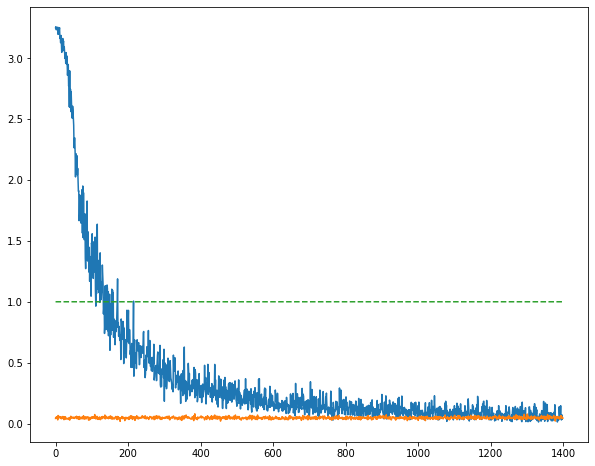

In [17]:
plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')


In [18]:
torch.save(model, "/Users/jackgaither/desktop/capstone2/project/models/mnist_model")

In [19]:
model = torch.load("/Users/jackgaither/desktop/capstone2/project/models/mnist_model")
model.eval()

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Prediction: h
Actual Label: h
Prediction: i
Actual Label: i
Prediction: i
Actual Label: i
Prediction: v
Actual Label: v
Correct predictions:  6434 /  7172 (0.897100)


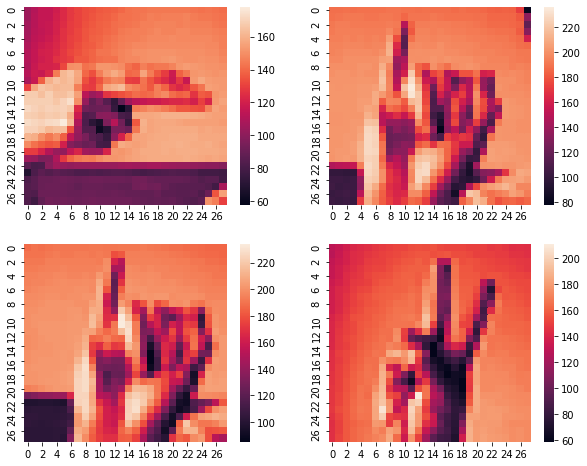

In [20]:
plt.figure(figsize=(10, 8))

sample = 30
pixels = test_data[sample].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = model(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 42
pixels = test_data[sample].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = model(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 100
pixels = test_data[sample].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = model(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 22
pixels = test_data[sample].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = model(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

predictions = model(Variable(test_data_formated))
model.test(torch.max(predictions.data, 1)[1], test_labels)